In [1]:
import numpy as np
import os
import os.path
import cv2
import matplotlib.pyplot as plt
from skimage.transform import rotate
from skimage.feature import hog
from skimage.exposure import rescale_intensity

import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
dir = './Dataset'

In [3]:
# создадим датафрем с нашими данными.
def create_df(directory):
    name = []
    for dirname, _, filenames in os.walk(directory):
        for filename in filenames:
          name.append([dirname.split('/')[-1], os.path.join(dirname, filename)])
    
    
    return pd.DataFrame(columns = ['category', 'way'], data = name).sample(frac=1)

df = create_df('./Dataset')
df.shape

(1680, 2)

In [4]:
# заменим категриальные признаки на числовые
slovar = {}
my_list = df['category'].unique()
for counter, value in enumerate(my_list):
    slovar[value] = counter

df['category'] = df['category'].map(slovar)

In [5]:
df.head()

,category,way
228,0,./Dataset/plate/IMG_20211122_105612_4.jpg
480,0,./Dataset/plate/IMG_20211130_215901_12.jpg
943,1,./Dataset/cup/IMG_20211130_160319_15.jpg
165,2,./Dataset/fork/IMG_20211206_084301.jpg
760,3,./Dataset/knife/IMG_20211120_173915_1.jpg


In [6]:
df.groupby("category")["way"].count() / df.shape[0] * 100

category
0    21.25
1    17.50
2    12.50
3    17.50
4    17.50
5    13.75
Name: way, dtype: float64

In [7]:
n_train = int(df.shape[0] * 0.7)
df_train = df[:n_train]
df_val = df[n_train:]

Затем применим фильтр Гаусса для сглаживания, уменьшим его и нормируем яркость

In [8]:
def first_prepare(img):
    # размытие (сглаживание)
    img = cv2.GaussianBlur(img, (15, 15), 3)

    # уменьшим размер
    img = cv2.resize(img, (64, 64))

    # нормализуем интенсивности от 0 до 255
    img = cv2.normalize(img, None, 0, 255, norm_type=cv2.NORM_MINMAX)
    
    return img

# img = first_prepare(img)
# plt.imshow(img, cmap="gray")

## Bag of words для исходной картинки (несегментированной)

### Составление словаря слов
Каждую картинку (исходный размер 64х64) разделим на ячейки 16х16 со смещением 8 пикселей. Итого получим 49 ячеек. 

Для каждой из них вычислим гистограмму направленных градиентов HOG по 9 направлением. Итого каждый объект (слово) будет представлять из себя вектор длины 9, из каждой картинки получим 49 слов.

Все слова из всех картинок разделим на кластеры с помощью алгоритмя K-means (количество кластеров попробуем разное, для начала - 25 штук).
Тогда наш словарь будет состоять из 25 слов.

In [9]:
def get_frames(image, image_name):
    # получает 49 векторов длины 9 из каждой картинки
    # и возвращает dataframe с этими векторами
    
    # исходный размер изображения 64*64
    win_size = (64, 64)
    block_size = (16, 16)
    block_stride = (8, 8)
    cell_size = (16, 16)
    n_bins = 9

    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, n_bins)

    winStride = (8, 8)
    padding = (0, 0) 
    hist = hog.compute(image, winStride, padding) 

    # количество ячеек 7 * 7, по 9 бинов в каждом = 441
    # сделаем resize в матрицу 49*9, чтобы каждая ячейка (слово) описывалась отдельно
    
    data = np.reshape(hist, (49, 9))
    df = pd.DataFrame(data)
    df["row"] = df.index % 7
    df["col"] = df.index // 7
    df["name"] = image_name
    
    return df[["name", "row", "col", 0, 1, 2, 3, 4, 5, 6, 7, 8]]

In [10]:
def all_frames(file_list):
    # для списка файлов получает векторы
    # и объединяет в один dataframe
    
    frames = None
    
    for f in file_list:
        image = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        image = first_prepare(image)
        # для получения сегментированного изображения
        # image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 33, 24)
        
        if frames is None:
            frames = get_frames(image, f)
            
        else:
            frames = pd.concat([frames, get_frames(image, f)], axis=0)
    
    frames.reset_index(drop=True, inplace=True)
    
    return frames

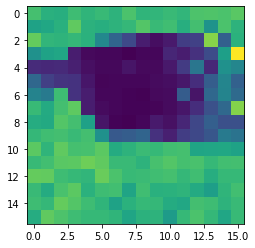

In [11]:
def frame_image(name, row, col):
    # по имени файла, номеру строки (от 0 до 6),
    # номеру колонки (от 0 до 6)
    # возвращает фрагмент изображения
    
    image = cv2.imread(name, cv2.IMREAD_GRAYSCALE)
    image = first_prepare(image)
    # для получения сегментированного изображения
    # image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 33, 24)
    
    frame = image[row * 8 : (row + 2) * 8, col * 8 : (col + 2) * 8]
    return frame

# пример работы функции
plt.imshow(frame_image("./Dataset/fork/IMG_20211119_084920.jpg", 3, 5))

In [12]:
# обучим K-means на наших данных
from sklearn.cluster import KMeans

n_clusters = 25

cls = KMeans(n_clusters=n_clusters)

# сформируем список файлов
file_list = df_train["way"].to_list()

# сформируем dataframe со словами, из него для обучения возьмем только часть колонок 
# название файла и месторасположение фрагмента не берем
train_frames_data = all_frames(file_list)
X_hog_train = train_frames_data[[0, 1, 2, 3, 4, 5, 6, 7, 8]]

# обучим алгоритм
cls.fit(X_hog_train)


KMeans(n_clusters=25, n_init=20)

Посмотрим на получившиеся кластеры. Для этого в dataframe с информацией о фрагментах всех изображений добавим значение кластера.

И посмотрим на объемы кластеров.

In [13]:
train_frames_data["cluster"] = cls.predict(X_hog_train)

train_frames_data["cluster"].value_counts()

0     19969
10     3694
7      3642
19     3087
16     3042
20     2720
8      2586
4      2214
24     2179
3      1359
13     1309
12     1289
11     1159
15     1112
14     1083
18     1027
2       876
22      851
21      714
5       706
9       637
23      630
1       620
17      611
6       508
Name: cluster, dtype: int64

Видно, что есть один наиболее многочисленный кластер и 24 менее многочисленных.

Для визуальной оценки кластеров возьмем несколько фрагментов самого многочисленного кластера:

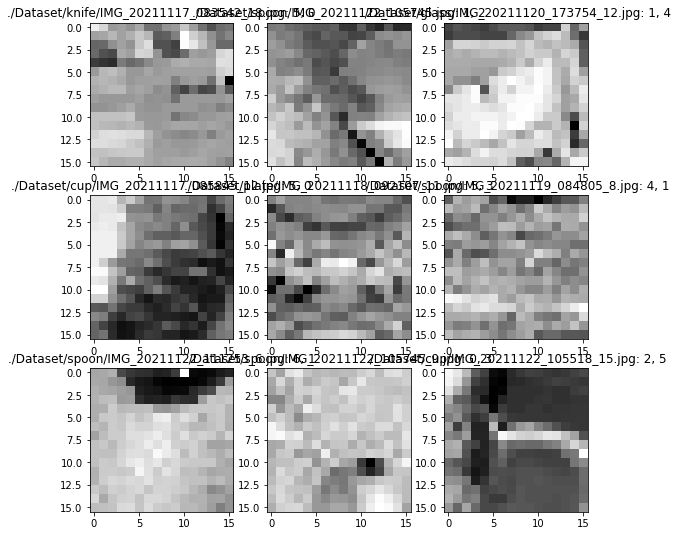

In [14]:
cluster = 0
sample = train_frames_data[train_frames_data["cluster"] == cluster].sample(n=9)
sample.reset_index(drop=True, inplace=True)

fig = plt.figure(figsize=(9, 9))

for i in range(9):
    name = sample.loc[i, "name"]
    row = sample.loc[i, "row"]
    col = sample.loc[i, "col"]

    plt.subplot(3, 3, i + 1)
    plt.imshow(frame_image(name, row, col), cmap='gray')
    plt.title(f"{name}: {row}, {col}")
    

И какого-нибудь кластера среднего размера

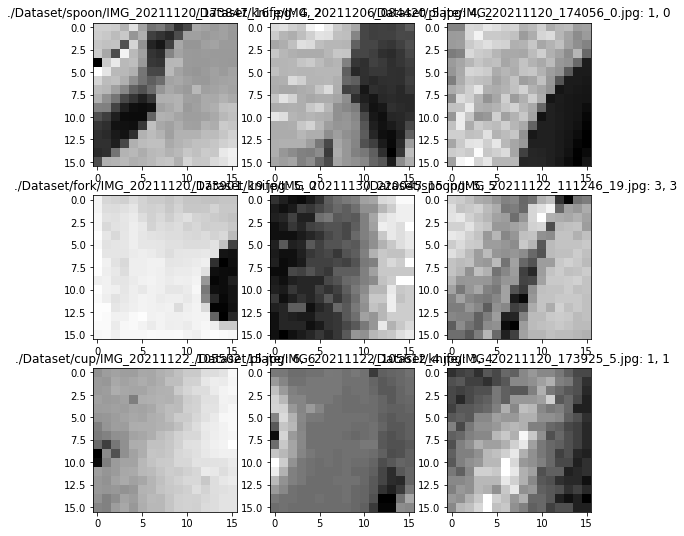

In [15]:
cluster = 13
sample = train_frames_data[train_frames_data["cluster"] == cluster].sample(n=9)
sample.reset_index(drop=True, inplace=True)

fig = plt.figure(figsize=(9, 9))

for i in range(9):
    name = sample.loc[i, "name"]
    row = sample.loc[i, "row"]
    col = sample.loc[i, "col"]

    plt.subplot(3, 3, i + 1)
    plt.imshow(frame_image(name, row, col), cmap='gray')
    plt.title(f"{name}: {row}, {col}")

### Построение feature vector для изображений

Теперь мы можем посмотреть на все 49 фрагментов изображения и определить, к какому из кластеров они относятся и записать частоту этого слова в соответствующую ячейку.

Так как наш словарь включает в себя 25 слов, то каждое изображение можно описать вектором длины 25, где на i-м месте стоит частота i-го слова.

Информация о номере кластера для каждого фрагмента каждого изображения у нас уже записана в dataframe, нам нужно только группировать ее по названию файла.

In [16]:
def create_features(data, vocab_volume):
    df_counts = (data[["name", "cluster", "row"]]
                 .groupby(["name", "cluster"], as_index=False)
                 .agg("count")
    )
    df_counts = df_counts.rename(columns={"row": "count"})
    # проверка на присутствие всех кластеров
    names_list = df_counts["name"].unique()
    for name in names_list:
        values_list = df_counts[df_counts["name"] == name]["cluster"].to_list() 
        for i in range(vocab_volume):          
            if i not in values_list:
                df_counts = df_counts.append({"name": name, "cluster": i, "count": 0}, ignore_index=True)
    
    
    df_counts_wide = df_counts.pivot_table(index=["name"], 
                                           columns=["cluster"], 
                                           values=["count"], 
                                           fill_value=0)
    df_counts_wide.columns = df_counts_wide.columns.get_level_values(1)
    
    
    return df_counts_wide

features_train = create_features(train_frames_data, n_clusters)
features_train.head()

cluster,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
name,,,,,,,,,,,,,,,,,,,,,
./Dataset/cup/IMG_20211117_085845.jpg,12,0,0,1,1,0,5,3,1,0,...,4,1,2,0,3,1,0,0,2,4
./Dataset/cup/IMG_20211117_085845_1.jpg,10,0,0,2,2,0,4,0,2,0,...,1,5,0,1,4,5,0,1,3,0
./Dataset/cup/IMG_20211117_085845_12.jpg,12,0,0,1,1,0,1,0,1,0,...,1,4,0,1,3,1,0,1,7,0
./Dataset/cup/IMG_20211117_085845_13.jpg,16,1,0,1,0,0,0,1,5,0,...,1,0,0,0,4,0,0,0,8,1
./Dataset/cup/IMG_20211117_085845_14.jpg,14,0,2,0,0,0,1,2,5,1,...,1,3,0,0,6,0,0,0,6,1


Теперь нужно склеить полученное описание с целевой переменной.

In [17]:
data_train = pd.merge(features_train, df_train, left_index=True, right_on="way").drop("way", axis=1)
data_train.reset_index(drop=True, inplace=True)

In [18]:
y_train = data_train.pop("category")
X_train = data_train

In [19]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,12,0,0,1,1,0,5,3,1,0,...,4,1,2,0,3,1,0,0,2,4
1,10,0,0,2,2,0,4,0,2,0,...,1,5,0,1,4,5,0,1,3,0
2,12,0,0,1,1,0,1,0,1,0,...,1,4,0,1,3,1,0,1,7,0
3,16,1,0,1,0,0,0,1,5,0,...,1,0,0,0,4,0,0,0,8,1
4,14,0,2,0,0,0,1,2,5,1,...,1,3,0,0,6,0,0,0,6,1


In [20]:
X_train.shape

(1176, 25)

In [21]:
y_train.head()

0    1
1    1
2    1
3    1
4    1
Name: category, dtype: int64

In [22]:
# сформируем X_val и y_val, объединим проделанную процедуру в функцию

def create_xy_data(df, clf_model):
    # df - dataframe именами файлов и категориями
    # clf_model - модель кластеризации
    
    file_list = df["way"].to_list()
    df_frames = all_frames(file_list)
    df_hog = df_frames[[0, 1, 2, 3, 4, 5, 6, 7, 8]]
    
    df_frames["cluster"] = clf_model.predict(df_hog)
    features = create_features(df_frames, clf_model.get_params()["n_clusters"])
    data = pd.merge(features, df, left_index=True, right_on="way").drop("way", axis=1)
    data.reset_index(drop=True, inplace=True)
    y = data.pop("category")
    X = data 
    return X, y

X_val, y_val = create_xy_data(df_val, cls)


In [23]:
X_val.shape

(504, 25)

In [24]:
# обучим SVM и XGBoost на наших данных

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe_svc = Pipeline([
    ('scaler_', StandardScaler()),
    ('model_', SVC(C=4))])


pipe_svc.fit(X_train, y_train)

pipe_xgbst = Pipeline([
    ('scaler_', StandardScaler()),
    ('model_', XGBClassifier(n_estimators=25, max_depth=4, verbosity=0))])


pipe_svc.fit(X_train, y_train)
pipe_xgbst.fit(X_train, y_train)


Pipeline(steps=[('scaler_', StandardScaler()),
                ('model_',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=4, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=25,
                               n_jobs=12, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=None, subsample=1,
                               tree_method='exact', validate_parameters

In [25]:
from sklearn.metrics import accuracy_score
print("accuracy SVC", accuracy_score(pipe_svc.predict(X_val), y_val), 
      "\naccuracy XGBoost", accuracy_score(pipe_xgbst.predict(X_val), y_val))

accuracy SVC 0.7738095238095238 
accuracy XGBoost 0.6567460317460317


Посмотрим теперь по кросс-валидации

In [26]:
from sklearn.model_selection import cross_validate, StratifiedKFold

# print("Cross validation for SVC:")
# print(cross_validate(pipe_svc, , y, cv=StratifiedKFold(n_splits=5), scoring='accuracy')["test_score"])

# print("Cross validation for XGBoost:")
# print(cross_validate(pipe_xgbst, X, y, cv=StratifiedKFold(n_splits=5), scoring='accuracy')["test_score"])

Теперь проверим на тестовых данных

In [26]:
df_test = create_df('./Test')
df_test["category"] = df_test["category"].map(slovar)

X_test, y_test = create_xy_data(df_test, cls)

In [27]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,6,1,0,0,3,0,3,7,2,0,...,2,4,0,9,2,1,2,0,0,1
1,4,1,0,1,2,0,0,9,1,0,...,1,3,1,10,3,2,2,0,2,0
2,6,3,1,2,3,0,0,10,5,0,...,1,2,0,2,3,0,0,0,0,3
3,6,1,0,2,2,0,1,5,0,0,...,1,3,1,12,1,0,1,0,1,2
4,5,1,0,1,2,0,1,5,0,0,...,1,2,3,4,3,3,1,0,0,2


In [28]:
accuracy_score(pipe_svc.predict(X_test), y_test)

0.3772893772893773

In [29]:
accuracy_score(pipe_xgbst.predict(X_test), y_test)

0.34798534798534797

Для дальнейшего подбора выберем SVC

### Подбор гиперпараметров

Попробуем подобрать размер словаря и параметры, чтобы улучшить качество модели.


In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe_hp = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVC())])


clfs = []
for n in range(20, 110, 10):
    clf = KMeans(n_clusters=n)
    clf.fit(X_hog_train)
    clfs.append(clf)

for clf in clfs:
    X_train, y_train = create_xy_data(df_train, clf)
    
    gs = GridSearchCV(pipe_hp,
                     param_grid={"model__C": [0.8 * x for x in range(1, 3)]})
    gs.fit(X_train, y_train)
    
    X_val, y_val = create_xy_data(df_val, clf)
    print(clf, accuracy_score(y_val, gs.predict(X_val)), gs.best_params_)

KMeans(n_clusters=20) 0.6785714285714286 {'model__C': 0.8}
KMeans(n_clusters=30) 0.7023809523809523 {'model__C': 1.6}
KMeans(n_clusters=40) 0.7182539682539683 {'model__C': 1.6}
KMeans(n_clusters=50) 0.7063492063492064 {'model__C': 1.6}
KMeans(n_clusters=60) 0.6884920634920635 {'model__C': 0.8}
KMeans(n_clusters=70) 0.7103174603174603 {'model__C': 1.6}
KMeans(n_clusters=80) 0.6726190476190477 {'model__C': 0.8}
KMeans(n_clusters=90) 0.7043650793650794 {'model__C': 1.6}
KMeans(n_clusters=100) 0.6924603174603174 {'model__C': 1.6}


Значения accuracy довольно высокие, но эта оценка завышена из-за специфики данных - у нас очень много аугментированных изображений, и они попадают и в обучающую, и в валидационную выборки.

Выберем размер словаря - 40 слов и снова посмотрим на результат на тестовых данных

In [32]:
cls = KMeans(n_clusters=40)

file_list_train = df_train["way"].to_list()
train_frames_data = all_frames(file_list_train)    
X_hog_train = train_frames_data[[0, 1, 2, 3, 4, 5, 6, 7, 8]]

cls.fit(X_hog_train)

X_train, y_train = create_xy_data(df_train, cls)

X_val, y_val = create_xy_data(df_val, cls)
    
pipe_1 = Pipeline([
    ('scaler_', StandardScaler()),
    ('model_', SVC(C=1.6))]).fit(X_train, y_train)
accuracy_score(y_val, pipe_1.predict(X_val))

0.7123015873015873

In [33]:
df_test = create_df('./Test')
df_test["category"] = df_test["category"].map(slovar)

X_test, y_test = create_xy_data(df_test, cls)

accuracy_score(pipe_1.predict(X_test), y_test)

0.4139194139194139

Результаты примерно такие же, как и при словаре в 25 слов. 

Посмотрим, на каких объектах модель ошибается чаще.

In [34]:
predict = pipe_1.predict(X_test)
test_result = pd.DataFrame(data = np.array([y_test, predict]).T,
                           columns = ["y_true", "y_predict"])

test_result["match"] = (test_result["y_true"] == test_result["y_predict"])
test_result.groupby("y_true")["match"].mean()

y_true
0    0.738095
1    0.904762
2    0.095238
3    0.460317
4    0.261905
5    0.000000
Name: match, dtype: float64

In [35]:
slovar

{'plate': 0, 'cup': 1, 'fork': 2, 'knife': 3, 'spoon': 4, 'glass': 5}

Лучше всего дело обстоит с тарелками и чашками. Хуже всего - с вилками и стаканами.

In [36]:
test_result.groupby(["y_true", "y_predict"]).count()

match
y_true y_predict       
0      0             31
       1              8
       3              1
       4              2
1      0              4
       1             38
2      0             12
       1              5
       2              4
       3             14
       4              7
3      0              9
       1             10
       2              5
       3             29
       4             10
4      0              7
       1              5
       2              3
       3             16
       4             11
5      0              6
       1             15
       3             16
       4              5

Чаще всего модель путает вилки с тарелками, а стаканы - с ножами. 

## Bag of words для сегментированной картинки

Для построения модели для сегментировнных изображений нужно раскомментить функцию adaptiveThreshold в двух местах)
Остальная процедура аналогичная.

При работе с сегментировнными изображениями качество модели немного лучше - на тестовых данных accuracy 0.4375. Но тоже не слишком высокое.